# Expriment 1
#### Examining the shift in the users interest toward popularity bias, In this expriment we evaluate the user interest toward popularity bias based on the history profile of each user 

In [1]:
import pandas as pd

ml_dataset = pd.read_csv("../artifacts/data_ingestion/ml_1m/ml-1m.inter", sep="\t")
ml_dataset = ml_dataset.rename(columns=
    {"user_id:token": "user", "item_id:token": "item", "rating:float": "rating", "timestamp:float": "time"}
)
ml_dataset.head()

,user,item,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [2]:
import numpy as np

proportions = [0.8, 0.2]

ordered_labels = {}
random_labels = {}

labels = ["train", "validation", "test"]
for user_id, group in ml_dataset.groupby(["user"]):
    n = len(group)
    group_sorted = group.sort_values(by="time", ascending=True)
    split_indices = [int(n * p) for p in proportions]
    split_indices[-1] = n - sum(split_indices[:-1])

    start_index = 0
    shuffled_index = group.sample(frac=1).index
    for i, n_instance in enumerate(split_indices):
        end_index = start_index + n_instance

        split_ordered_idx = group_sorted[start_index:end_index].index
        split_random_index = shuffled_index[start_index:end_index]

        labels_array = np.repeat(labels[i], n_instance)
        ordered_labels.update(dict(zip(split_ordered_idx, labels_array)))
        random_labels.update(dict(zip(split_random_index, labels_array)))

        start_index = end_index

ml_dataset["random_split"] = ml_dataset.index.map(random_labels)
ml_dataset["time_split"] = ml_dataset.index.map(ordered_labels)
ml_dataset = ml_dataset.sort_values(by=["user", "time"], ignore_index=True)
ml_dataset.head(50)


,user,item,rating,time,random_split,time_split
0,1,3186,4,978300019,train,train
1,1,1270,5,978300055,train,train
2,1,1721,4,978300055,train,train
3,1,1022,5,978300055,validation,train
4,1,2340,3,978300103,validation,train
5,1,1836,5,978300172,train,train
6,1,3408,4,978300275,train,train
7,1,2804,5,978300719,train,train
8,1,1207,4,978300719,train,train
9,1,1193,5,978300760,train,train


In [3]:
from tools import generate_user_item_matrix
from tools import group_items_based_popularity
from tools import create_user_item_map
from tools import calc_item_popularity

user_map, item_map = create_user_item_map(ml_dataset)
sparse_matrix = generate_user_item_matrix(ml_dataset, user_map, item_map)
item_popularity = calc_item_popularity(sparse_matrix)
item_groups = group_items_based_popularity(item_popularity, proportions=[0.2, 0.6, 0.2])

In [4]:
mask_random = ml_dataset["random_split"] == "train"
train_data_random = ml_dataset.loc[mask_random, :].copy()
valid_data_random = ml_dataset.loc[~mask_random, :].copy()

train_user_item_random = generate_user_item_matrix(train_data_random, user_map, item_map)
valid_user_item_random = generate_user_item_matrix(valid_data_random, user_map, item_map)

display(train_user_item_random.shape)
display(valid_user_item_random.shape)

(6040, 3706)

(6040, 3706)

In [5]:
from reylearn.metrics.probability import jsd, kl_divergence
from tools import calculate_pc

p_c_random = calculate_pc(train_user_item_random.toarray(), item_groups)
q_c_random = calculate_pc(valid_user_item_random.toarray(), item_groups)
user_jsd_random = jsd(p_c_random, q_c_random)
user_jsd_random.mean()

np.float64(0.04122167937685719)

In [6]:
mask_ordered = ml_dataset["time_split"] == "train"
train_data_ordered = ml_dataset.loc[mask_ordered, :].copy()
valid_data_ordered = ml_dataset.loc[~mask_ordered, :].copy()

train_user_item_ordered = generate_user_item_matrix(train_data_ordered, user_map, item_map)
valid_user_item_ordered = generate_user_item_matrix(valid_data_ordered, user_map, item_map)

display(train_user_item_ordered.shape)
display(valid_user_item_ordered.shape)

(6040, 3706)

(6040, 3706)

In [7]:
from reylearn.metrics.probability import jsd, kl_divergence
from tools import calculate_pc

p_c_ordered = calculate_pc(train_user_item_ordered.toarray(), item_groups)
q_c_ordered = calculate_pc(valid_user_item_ordered.toarray(), item_groups)
user_jsd_ordered = jsd(p_c_ordered, q_c_ordered)
user_jsd_ordered.mean()

np.float64(0.07773823607704947)

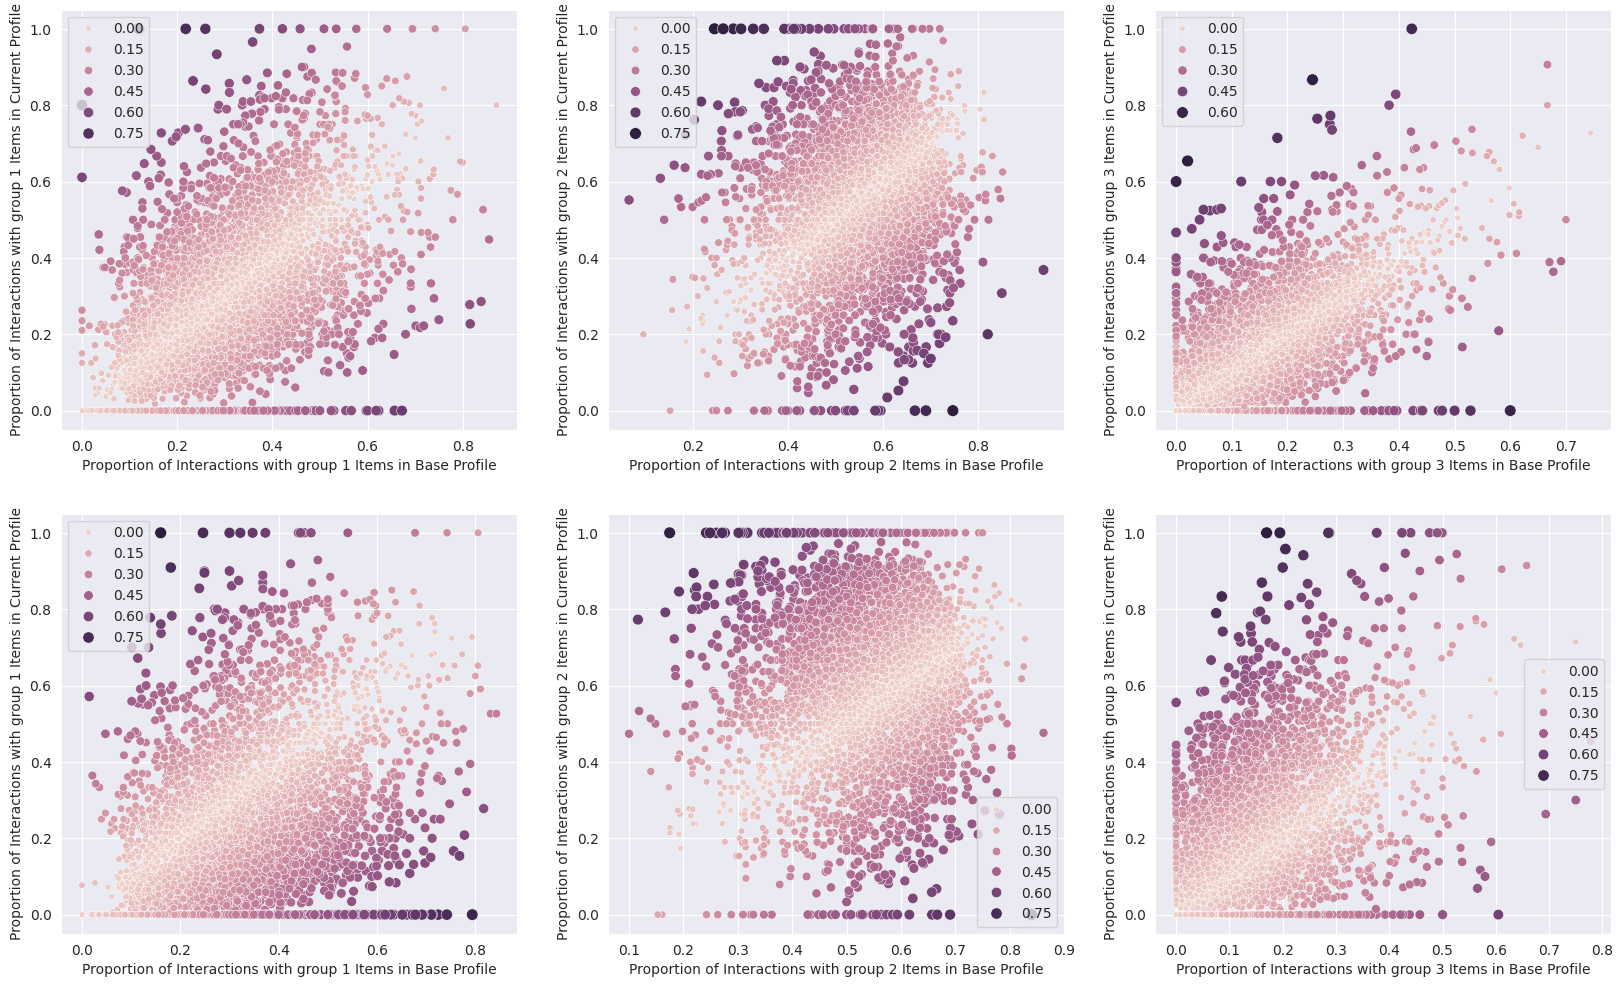

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    for i in range(3):
        diff_random = np.abs(p_c_random[:, i] - q_c_random[:, i])
        diff_ordered = np.abs(p_c_ordered[:, i] - q_c_ordered[:, i])
        ax_random = axes.ravel()[i]
        ax_ordered = axes.ravel()[i + 3]

        sns.scatterplot(x=p_c_random[:, i], y=q_c_random[:, i], size=diff_random, hue=diff_random, ax=ax_random)
        sns.scatterplot(x=p_c_ordered[:, i], y=q_c_ordered[:, i], size=diff_ordered, hue=diff_ordered, ax=ax_ordered)

        ax_random.set_xlabel(f"""Proportion of Interactions with group {i+1} Items in Base Profile""")
        ax_random.set_ylabel(f"""Proportion of Interactions with group {i+1} Items in Current Profile""")

        ax_ordered.set_xlabel(f"""Proportion of Interactions with group {i+1} Items in Base Profile""")
        ax_ordered.set_ylabel(f"""Proportion of Interactions with group {i+1} Items in Current Profile""")

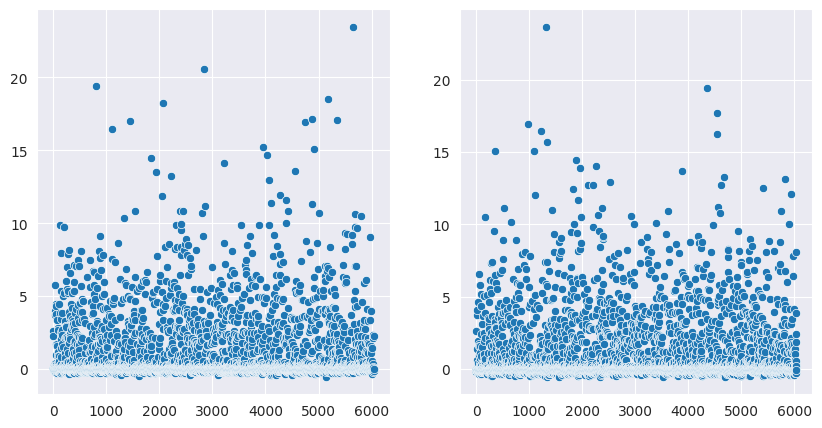

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

kl_ordered = kl_divergence(p_c_ordered[:, 2].reshape(-1, 1), q_c_ordered[:, 2].reshape(-1, 1))
kl_random = kl_divergence(p_c_random[:, 2].reshape(-1, 1), q_c_random[:, 2].reshape(-1, 1))


with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    sns.scatterplot(x=np.arange(len(kl_random)), y=kl_random, ax=axes.ravel()[0])
    sns.scatterplot(x=np.arange(len(kl_ordered)), y=kl_ordered, ax=axes.ravel()[1])

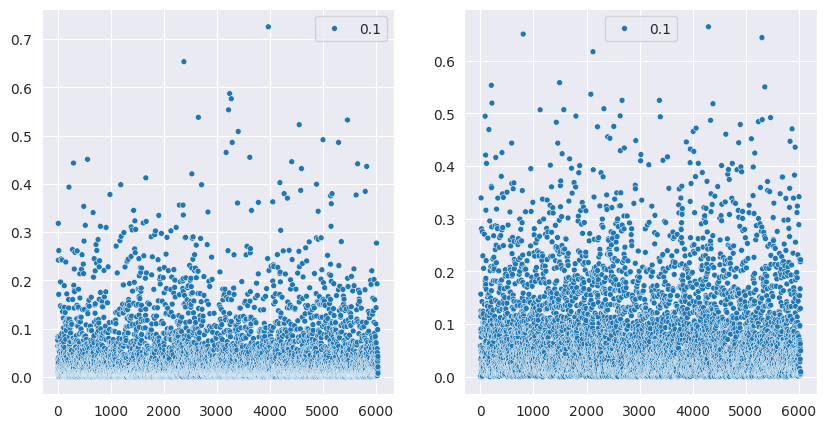

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

jsd_ordered = jsd(p_c_ordered, q_c_ordered)
jsd_random = jsd(p_c_random, q_c_random)


with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    sns.scatterplot(x=np.arange(len(kl_random)), y=jsd_random, size=0.1, ax=axes.ravel()[0])
    sns.scatterplot(x=np.arange(len(kl_ordered)), y=jsd_ordered, size=0.1, ax=axes.ravel()[1])

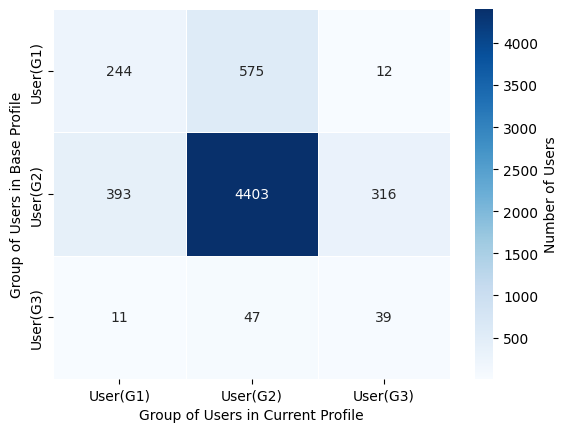

In [11]:
user_consumption_type_before = np.argmax(p_c_ordered, axis=1)
user_consumption_type_after = np.argmax(q_c_ordered, axis=1)

n_groups = p_c_ordered.shape[1]
transition_matrix = np.zeros((n_groups, n_groups), dtype=int)

for i in range(n_groups):
    for j in range(n_groups):
        count = np.sum((user_consumption_type_before == i) & (user_consumption_type_after == j))
        transition_matrix[i, j] = count

group_labels = ["User(G1)", "User(G2)", "User(G3)"]
df_transition = pd.DataFrame(transition_matrix, index=group_labels, columns=group_labels)


sns.heatmap(df_transition, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar_kws={"label": "Number of Users"})

plt.ylabel("Group of Users in Base Profile")
plt.xlabel("Group of Users in Current Profile")
plt.show()

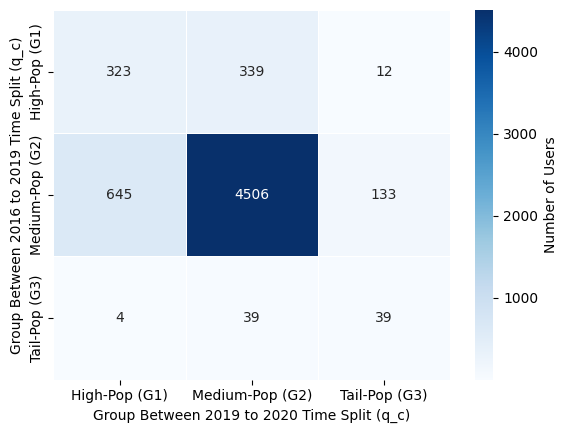

In [15]:
user_consumption_type_before = np.argmax(p_c_random, axis=1)
user_consumption_type_after = np.argmax(q_c_random, axis=1)

n_groups = p_c_random.shape[1]
transition_matrix = np.zeros((n_groups, n_groups), dtype=int)

for i in range(n_groups):
    for j in range(n_groups):
        count = np.sum((user_consumption_type_before == i) & (user_consumption_type_after == j))
        transition_matrix[i, j] = count

group_labels = ["High-Pop (G1)", "Medium-Pop (G2)", "Tail-Pop (G3)"]
df_transition = pd.DataFrame(transition_matrix, index=group_labels, columns=group_labels)


sns.heatmap(df_transition, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar_kws={"label": "Number of Users"})

plt.ylabel("Group Between 2016 to 2019 Time Split (q_c)")
plt.xlabel("Group Between 2019 to 2020 Time Split (q_c)")
plt.show()